# Fuel consumption dataset

This notebook explores the datasets from  https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64 between 1995 and 2022


# TO DO
Selecting the features can be left to the caller, or can be automated e.g. apply a chi-squared statistical test to rank the impact of each feature on the concept label and discard the less impactful features prior to model training.

In [1]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import scale
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

In [2]:
def box_plot(dataframe, col_list_float, plot_kind):
    """
    This function generates boxplots to show distribution and outliers of various parameters
    """
    
   
    x_val = 1
    y_val = len(col_list_float)
        
    if len(dataframe['model_year'].unique()) ==1:
        title_year = dataframe['model_year'].min()
    else:
        title_year = f'{dataframe["model_year"].min()} - {dataframe["model_year"].max()}'
        
    fig1, axes = plt.subplots(x_val,y_val , sharey=True, figsize=(18,6))
    
    k=0
    for i in range(0,x_val):
        for j in range(0,y_val):

            variable= col_list_float[k].lower()
            if plot_kind=="box":
                sns.boxplot(ax=axes[j], data=dataframe, x=variable)
                fig1.suptitle(f'Outlier identification by vehicle class {title_year}')
            elif plot_kind=="hist":
                sns.histplot(ax=axes[j], data=dataframe, x=variable,bins=10)
                fig1.suptitle(f'Distribution of data {title_year}')
            k+=1
    plt.show()

In [3]:
def find_outliers_tukey(x):
    
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indeces = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indeces])
    
    return outlier_values

def find_outliers_kde(x):
    x_scaled = scale(list(map(float,x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw='scott',fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred<0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]
    
    return outlier_value

### Read data

In [4]:
folder = "C:/Users/Laura GF/Documents/GitHub/machine-learning-capstone/data/"
raw_data = f'{folder}raw-data/'
clean_data = f'{folder}clean-data/'


file_name_2022_1995 = "1995_2022_vehicle_fuel_consumption.csv"

In [5]:


# Master df
master_df = pd.read_csv(Path(folder + "clean-data",f'{file_name_2022_1995}'))

## Clean data

In [ ]:
master_df = pd.get_dummies(master_df, columns=['transmission_type', 'mapped_fuel_type'])

#### NaN values in CO2 rating and smog rating columns are due to non-existing ratings between the years 1995 - 2015

In [6]:
master_df['fuel_type'].unique()

array(['Z', 'X', 'D', 'E', 'N'], dtype=object)

In [8]:
master_df['mapped_fuel_type']

0        premium gasoline
1        premium gasoline
2        premium gasoline
3        premium gasoline
4        premium gasoline
               ...       
43923    premium gasoline
43924    premium gasoline
43925    premium gasoline
43926    premium gasoline
43927    premium gasoline
Name: mapped_fuel_type, Length: 43928, dtype: object

## Summary stats

In [9]:
master_df.describe()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears
count,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,43928.000000,7171.000000,6061.000000,42627.000000
mean,2007.924012,3.393833,5.886655,13.523101,9.566352,11.743018,25.768781,266.098115,4.659880,4.674311,5.476764
std,7.250467,1.336548,1.779580,3.667994,2.552349,3.127989,7.030849,64.790087,1.638001,1.791209,1.356932
min,1995.000000,0.800000,2.000000,3.500000,3.200000,3.600000,10.000000,83.000000,1.000000,1.000000,1.000000
25%,2002.000000,2.300000,4.000000,11.000000,7.800000,9.600000,21.000000,221.000000,4.000000,3.000000,4.000000
50%,2008.000000,3.200000,6.000000,13.100000,9.100000,11.300000,25.000000,258.000000,5.000000,5.000000,5.000000
75%,2013.000000,4.300000,8.000000,15.600000,11.000000,13.500000,29.000000,306.000000,6.000000,6.000000,6.000000
max,2022.000000,8.400000,16.000000,33.300000,22.100000,27.500000,78.000000,633.000000,10.000000,8.000000,10.000000


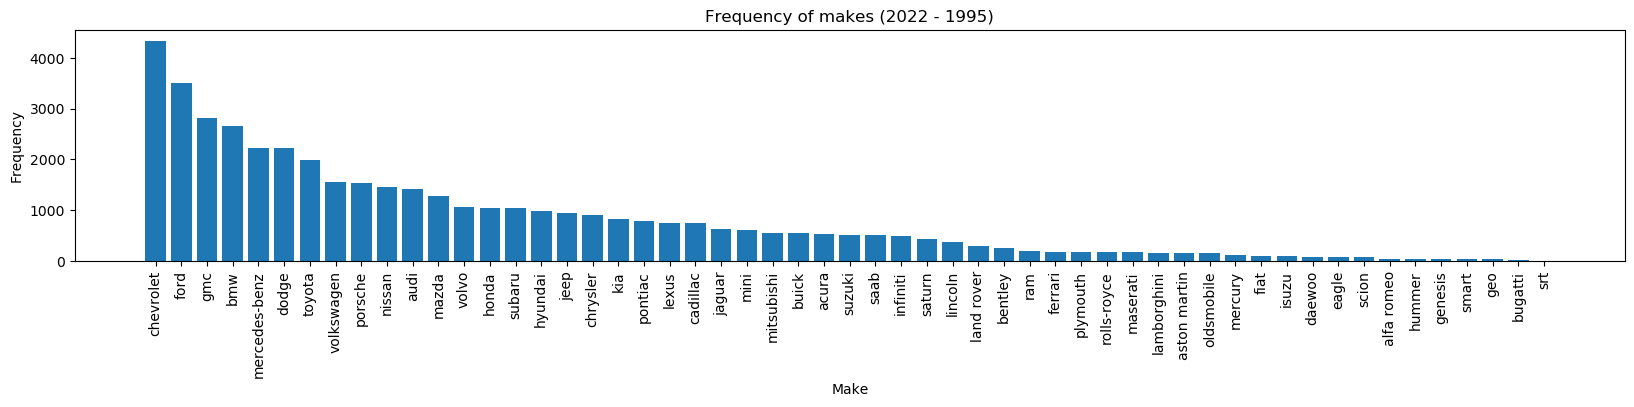

In [10]:
models = master_df.groupby("make_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = models['make_'], height = models['count'])
plt.xticks(rotation=90)
plt.xlabel("Make")
plt.ylabel("Frequency")
plt.title("Frequency of makes (2022 - 1995)")
plt.show()

In [ ]:
vehicle_class = master_df.groupby("vehicleclass_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(x = vehicle_class['vehicleclass_'], height = vehicle_class['count'])
plt.xticks(rotation=90)
plt.xlabel("Vehicle class")
plt.ylabel("Frequency")
plt.title("Frequency of vehicle class (2022 - 1995)")
plt.show()

In [ ]:
wheel_drive = master_df.groupby("type_of_wheel_drive").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,3)
plt.bar(x = wheel_drive['type_of_wheel_drive'], height = wheel_drive['count'])
plt.xticks(rotation=90)
plt.xlabel("Wheel drive type")
plt.ylabel("Frequency")
plt.title("Frequency of wheel drive type (2022 - 1995)")
plt.show()

In [ ]:
transmission = master_df.groupby("transmission_").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = transmission['transmission_'], height = transmission['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of transmission")
plt.ylabel("Frequency")
plt.title("Frequency of transmission type (2022 - 1995)")
plt.show()

In [ ]:
sns.histplot(data=master_df, x='number_of_gears', bins=5)
plt.title("Distribution: number of gears")
plt.show()

In [ ]:
transmission_type = master_df.groupby("transmission_type").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = transmission_type['transmission_type'], height = transmission_type['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of transmission")
plt.ylabel("Frequency")
plt.title("Frequency of transmission type (2022 - 1995)")
plt.show()

In [ ]:
fuel_type = master_df.groupby("mapped_fuel_type").count()['model_year'].reset_index().rename(columns={"model_year":"count"}).sort_values(by="count", ascending=False)
plt.rcParams["figure.figsize"] = (10,5)
plt.bar(x = fuel_type['mapped_fuel_type'], height = fuel_type['count'])
plt.xticks(rotation=90)
plt.xlabel("Type of fuel")
plt.ylabel("Frequency")
plt.title("Frequency of fuel type (2022 - 1995)")
plt.show()

### Outliers and scaling

In [ ]:


fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',
                  ]     

engine_info  = ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)','smog_rating']

In [ ]:
outliers = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))
    
for item in engine_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df[item]))
    print(item, len(outliers[item]))

In [ ]:
len(outliers['fuelconsumption_city(l/100km)'])

### The data has a positive skew

In [ ]:

box_plot(master_df,fuel_info,"hist")

In [ ]:
box_plot(master_df,fuel_info,"box")

In [ ]:
engine_info  = ['EngineSize_(L)','Cylinders_']
box_plot(master_df,engine_info,'hist')

In [ ]:
engine_info  = ['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)','smog_rating']
box_plot(master_df,engine_info,'box')

In [ ]:
master_df[~master_df['co2_rating'].isna()]

In [ ]:
non_na_rating = master_df[~master_df['co2_rating'].isna()]
box_plot(non_na_rating,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

### Using natural logarithm

In [ ]:
master_df_log_app = master_df.copy()

In [ ]:
fuel_info = [
              'fuelconsumption_city(l/100km)','fuelconsumption_hwy(l/100km)',	
              'fuelconsumption_comb(l/100km)','fuelconsumption_comb(mpg)',]
    
engine_info  = ['enginesize_(l)','co2emissions_(g/km)','smog_rating']

In [ ]:
for item in fuel_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))
    
for item in engine_info:
    master_df_log_app[item] = master_df_log_app[item].apply(lambda x: np.log(x))

In [ ]:
master_df_log_app.head()

In [ ]:
box_plot(master_df_log_app,fuel_info,"hist")


In [ ]:
box_plot(master_df_log_app,fuel_info,"box")

In [ ]:
box_plot(master_df_log_app,engine_info,"box")

In [ ]:
outliers_log = {}
for item in fuel_info:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))
    
for item in ['enginesize_(l)','cylinders_','co2_rating','co2emissions_(g/km)']:
    outliers[item] = np.sort(find_outliers_tukey(master_df_log_app[item]))
    print(item, len(outliers[item]))

In [ ]:
non_na_rating_log = master_df_log_app[~master_df_log_app['co2_rating'].isna()]
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"box")

In [ ]:
box_plot(non_na_rating_log,['EngineSize_(L)','Cylinders_','co2_rating','CO2Emissions_(g/km)'],"hist")

In [ ]:
corr_matrix_non_na_log = non_na_rating_log.corr()



In [ ]:
corr_matrix = master_df.corr()
fig_corr = sns.heatmap(corr_matrix, annot=True)
fig_corr.figure.savefig("./plots/correlation_matrix.png") 
plt.title("Correlation matrix")
plt.show()

In [ ]:
corr_dummy = dummy_df.corr()
fig_corr2 = sns.heatmap(corr_dummy, annot=True)
#fig_corr2.figure.savefig("./plots/correlation_matrix.png") 
plt.title("Correlation matrix")
plt.show()


In [ ]:
sns.heatmap(corr_matrix_non_na_log, annot=True)

plt.show()

## Predicting CO2 ratings for remaining values - feature engineering

#### Target variable: co2_rating

#### Independent variables: 

1. engine_size(l),

2. fuelconsumption_city(l/100km), 

3. fuelconsumption_hwy(l/100km),

4. fuelconsumption_comb(l/100km),

5. fuelconsumption_comb(mpg)

6. co2emissions_(g/km)

7. (maybe) cylinders_ 

In [ ]:
entries_with_scores = master_df_log_app[master_df_log_app['model_year']>=2017]
entries_with_scores.isna().sum()

In [ ]:
#fig = sns.pairplot(entries_with_scores, hue="type_of_fuel")
#fig.savefig("./plots/pairplot-by-fuel-type.png") 
#plt.show()

In [ ]:
#entries_with_scores['co2_rating'] = entries_with_scores['co2_rating'].astype('int').astype('str')

In [ ]:
entries_with_scores['co2_rating'].unique()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import make_column_transformer

kf = KFold(n_splits=10)
folds = StratifiedGroupKFold(n_splits=10)

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
Y = entries_with_scores['co2_rating']

X = entries_with_scores[['enginesize_(l)','cylinders_','fuelconsumption_city(l/100km)',
                         'fuelconsumption_hwy(l/100km)', 'fuelconsumption_comb(l/100km)', 
                         'fuelconsumption_comb(mpg)','co2emissions_(g/km)']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

In [ ]:
lr_sc = []
sv_sc = []
rf_sc = []
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index],\
                                        Y.iloc[train_index], Y.iloc[test_index] 
    lr_sc.append(get_score(LinearRegression(), X_train, X_test, y_train, y_test))
    
    ### NEED TO REVIEW https://scikit-learn.org/stable/modules/preprocessing.html
    sv_sc.append(get_score(GradientBoostingRegressor(), X_train, X_test, y_train, y_test))
    rf_sc.append(get_score(RandomForestClassifier(), X_train, X_test, y_train, y_test))

### Try xgboost, lightgbm 

### Next, try neural network model

In [ ]:
lr_sc

In [ ]:
sv_sc

In [ ]:
rf_sc

In [ ]:
cross_val_score(LinearRegression(), X, Y)

In [ ]:
cross_val_score(GradientBoostingRegressor(n_estimators=40), X, Y)

In [ ]:
cross_val_score(RandomForestClassifier(n_estimators=100), X, Y)

#### Predicting

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)
lm_predictions = lm.predict(X_test)


gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gmb_predictions = gbm.predict(X_test)

In [ ]:
lm_mae = mean_absolute_error(lm_predictions, y_test)
# lm_rmse = np.sqrt(mean_squared_error(lm_predictions, y_test),y_test)

gbm_mae = mean_absolute_error(gmb_predictions, y_test)
# gbm_rmse = np.sqrt(mean_squared_error(gmb_predictions, y_test), y_test)

In [ ]:
print(lm_mae)
print(gbm_mae)

GradientBoostingRegressor is slightly more accurate than gradient boosting.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, gmb_predictions)